In [7]:
import pandas as pd
import numpy as np
import requests
import json
import time
from scipy.optimize import linear_sum_assignment

In [9]:
input_csv=input('Enter the csv file name: ')

Enter the csv file name:  central_bus_data


In [10]:
bus_df=pd.read_csv(f'{input_csv}.csv')
bus_df

,Sl No,College/Institute,Vendor Name,Vehicle Number,Route No,Driver Point Latitude,Driver Point Longitude,Driver Point Name,First Pickup Pt. Latitude,First Pickup Pt. Longitude,First Pickup Point Name,Seat Capacity
0,216,Amity University,Baghirathi,KA51AJ8295,A7,12.987582,77.600954,Shivaji Nagar,13.028943,77.567725,Ramaiah Hospital,33
1,218,AmityUniversity,Baghirathi,KA51AJ8298,A4,13.027588,77.710653,KR Puram,13.008776,77.692368,KR Puram,33
2,219,Amity University,Baghirathi,KA51AJ8291,A6,13.032832,77.609844,Shivaji Nagar,12.964512,77.649514,Leela Palace Rd,33
3,220,Amity University,Baghirathi,KA51AJ8296,A8,13.091024,77.580596,Goraguntepalya,13.039833,77.519832,Jalahalli,33
4,221,Amity University,Baghirathi,KA53AC0344,A5,13.012663,77.607487,Kadubeesanahall,12.934740,77.690393,"Kadubeesanahalli, Opp. Wells Fargo",53
...,...,...,...,...,...,...,...,...,...,...,...,...
109,553,Harrow,Baghirathi,KA53AB1810,H1,12.996135,77.757787,whitefield,13.030863,77.665129,Oakwood aptr,18
110,554,Harrow,Baghirathi,KA50A5968,H2,13.017085,77.657374,banaswadi,13.020205,77.656504,Horamavu Signal,41
111,555,Harrow,Baghirathi,KA53AB1811,H3,12.985176,77.601569,Shivaji Nagar,12.950439,77.642715,Domlur EGL,18
112,556,Harrow,Baghirathi,KA53D5405,H4,13.099021,77.574234,yelahanka new twn,13.064409,77.578175,"1822 C Block, 24th Cross, 5th B Main Road, Sah...",41


In [45]:
cluster_name=input('Name of the current Cluster: ')

Name of the current Cluster:  NPS


In [21]:
driver_df=bus_df[['Vehicle Number', 'Route No', 'Driver Point Latitude', 'Driver Point Longitude', 'Driver Point Name', 'College/Institute']].rename(columns={
    'Vehicle Number':'bus', 
    'Route No': 'route',
    'Driver Point Latitude': 'dlat',
    'Driver Point Longitude': 'dlon',
    'Driver Point Name': 'dname',
    'College/Institute': 'cname'
})
pickup_df=bus_df[['Vehicle Number', 'Route No', 'First Pickup Pt. Latitude', 'First Pickup Pt. Longitude', 'First Pickup Point Name', 'College/Institute']].rename(columns={
    'Vehicle Number':'bus', 
    'Route No': 'route',
    'First Pickup Pt. Latitude': 'plat',
    'First Pickup Pt. Longitude': 'plon',
    'First Pickup Point Name': 'pname',
    'College/Institute': 'cname'
})

In [22]:
driver_df=driver_df.set_index('bus')
driver_df.head()

,route,dlat,dlon,dname,cname
bus,,,,,
KA51AJ8295,A7,12.987582,77.600954,Shivaji Nagar,Amity University
KA51AJ8298,A4,13.027588,77.710653,KR Puram,AmityUniversity
KA51AJ8291,A6,13.032832,77.609844,Shivaji Nagar,Amity University
KA51AJ8296,A8,13.091024,77.580596,Goraguntepalya,Amity University
KA53AC0344,A5,13.012663,77.607487,Kadubeesanahall,Amity University


In [24]:
depot_names = ['NPS Parking', 'Dps Parking', 'MAHE']  

driver_df['is_depot'] = driver_df['dname'].isin(depot_names)
driver_df

,route,dlat,dlon,dname,cname,is_depot
bus,,,,,,
KA51AJ8295,A7,12.987582,77.600954,Shivaji Nagar,Amity University,False
KA51AJ8298,A4,13.027588,77.710653,KR Puram,AmityUniversity,False
KA51AJ8291,A6,13.032832,77.609844,Shivaji Nagar,Amity University,False
KA51AJ8296,A8,13.091024,77.580596,Goraguntepalya,Amity University,False
KA53AC0344,A5,13.012663,77.607487,Kadubeesanahall,Amity University,False
...,...,...,...,...,...,...
KA53AB1810,H1,12.996135,77.757787,whitefield,Harrow,False
KA50A5968,H2,13.017085,77.657374,banaswadi,Harrow,False
KA53AB1811,H3,12.985176,77.601569,Shivaji Nagar,Harrow,False


In [26]:
pickup_df=pickup_df.set_index('bus')
pickup_df.head()

,route,plat,plon,pname,cname
bus,,,,,
KA51AJ8295,A7,13.028943,77.567725,Ramaiah Hospital,Amity University
KA51AJ8298,A4,13.008776,77.692368,KR Puram,AmityUniversity
KA51AJ8291,A6,12.964512,77.649514,Leela Palace Rd,Amity University
KA51AJ8296,A8,13.039833,77.519832,Jalahalli,Amity University
KA53AC0344,A5,12.934740,77.690393,"Kadubeesanahalli, Opp. Wells Fargo",Amity University


In [69]:
base_url= "http://localhost:5000/route/v1/driving"

In [40]:
def osrm_calculate(lat1, lon1, lat2, lon2): #input parameters as default lat,lon
    src=f'{lon1},{lat1};{lon2},{lat2}'
    curl=f"http://localhost:5000/route/v1/driving/{src}?overview=false"
    time.sleep(0.2)
    try:
        json_response=requests.get(curl).json()
        return json_response['routes'][0]['distance']/1000
    except Exception as exc:
        print(f"OSRM error at {lat1},{lon1} to {lat2},{lon2}: {exc}")
        return np.inf

In [166]:
bus_coords = driver_df.set_index(driver_df.index)[['dlat', 'dlon']].to_dict('index')
buses = list(bus_coords.keys())

pickup_coords = pickup_df.set_index(pickup_df.index)[['plat', 'plon']].to_dict('index')
pickups = list(pickup_coords.keys())

distance_mat=pd.DataFrame(index=buses, columns=pickups, dtype=float)


In [ ]:
RUN BELOW CELL TO COMPUTE DISTANCE MATRIX

In [ ]:
buffer cell

In [153]:
distance_cache = {}  

for bus in buses:
    driver_institute = driver_df.loc[bus, 'cname']
    driver_is_depot = driver_df.loc[bus, 'is_depot']
    driver_coords = (driver_df.loc[bus, 'dlat'], driver_df.loc[bus, 'dlon'])

    if driver_coords in distance_cache:
        distance_mat.loc[bus] = distance_cache[driver_coords]
        continue

    distances = {}
    for pickup in buses:
        pickup_institute = pickup_df.loc[pickup, 'cname']

        if driver_is_depot and driver_institute != pickup_institute:
            distances[pickup] = np.inf
            continue

        pickup_coords = (pickup_df.loc[pickup, 'plat'], pickup_df.loc[pickup, 'plon'])
        distance = osrm_calculate(driver_coords[0], driver_coords[1], pickup_coords[0], pickup_coords[1])
        distances[pickup] = distance

    distance_mat.loc[bus] = distances
    distance_cache[driver_coords] = distances

distance_mat.to_csv(f'{input_csv}_matrix.csv', index=True)


OSRM error at 12.855323,77.6726 to 12.90782,77.60426: HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /route/v1/driving/77.6726,12.855323;77.60426,12.90782?overview=false (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B33C615A60>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))
OSRM error at 12.855323,77.6726 to 12.95573552,77.59277575: HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /route/v1/driving/77.6726,12.855323;77.59277575,12.95573552?overview=false (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001B33C616990>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))
OSRM error at 12.855323,77.6726 to 13.049924,77.592684: HTTPConnectionPool(host='localhost', port=5000): Max retries excee


KeyboardInterrupt



In [17]:
dist_mat_name=input('Distance matrix name: ')

Distance matrix name:  central_bus_data_matrix


In [18]:
distance_mat=pd.read_csv(f'{dist_mat_name}.csv')
distance_mat.index=distance_mat.columns
distance_mat

,KA51AJ8295,KA51AJ8298,KA51AJ8291,KA51AJ8296,KA53AC0344,KA53AC0345,KA51B9664,KA53AB4252,KA439840,KA43A0245,...,KA53D2719,KA53B6967,KA53B6964,KA07A9089,KA53AB1814,KA53AB1810,KA50A5968,KA53AB1811,KA53D5405,KA53AB1808
KA51AJ8295,7.4458,12.4354,8.6460,12.8511,17.6049,7.8932,43.5154,15.2630,13.1090,9.9507,...,12.2670,29.1975,30.5751,16.8184,12.6729,10.1867,8.6094,9.9765,10.5398,7.0475
KA51AJ8298,22.1577,4.4784,12.6031,27.5631,13.9877,23.3869,48.4766,21.0771,3.9962,25.4444,...,20.3353,35.0116,32.6334,22.6325,19.2296,6.7645,7.7092,14.9013,19.2629,22.5411
KA51AJ8291,6.5839,10.7597,13.1729,13.8793,22.6676,12.7032,39.0184,11.6189,11.4334,15.5236,...,18.1706,25.5534,26.9310,13.1743,8.5973,7.6149,6.0376,14.5034,7.9972,11.2966
KA51AJ8296,13.1192,20.6813,23.4224,12.2533,32.9171,18.8221,29.0514,1.9839,21.3549,20.4052,...,28.5156,15.5864,19.7266,2.1213,3.7738,17.5364,15.9591,24.7529,8.4746,16.1781
KA53AC0344,6.6732,11.6201,9.8011,13.9686,19.2959,12.3779,44.6329,14.3616,12.2937,14.4354,...,16.5656,28.2960,30.3457,15.9170,11.3400,8.7794,7.2020,11.1317,9.5577,11.5321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KA53AB1810,26.7393,9.0600,16.2116,32.1447,12.3370,27.9684,73.6941,30.9567,9.9451,30.0260,...,18.6542,44.8911,34.7387,32.5121,29.1091,15.9813,15.6149,17.6983,29.8334,27.1227
KA50A5968,14.2489,5.3209,8.5825,19.6543,13.6906,16.3392,43.8622,16.4627,5.9945,18.3967,...,16.3147,30.3972,30.3819,18.0181,14.6151,2.1630,0.5856,10.8807,12.0547,15.4934
KA53AB1811,7.6720,11.7652,7.8382,13.7437,17.5876,7.8884,44.4080,15.4893,12.4388,9.9459,...,11.4592,29.4237,30.8013,17.0446,12.8992,9.9004,8.3231,9.1687,10.7661,7.0427
KA53D5405,12.1298,21.6831,23.5410,11.2639,33.0357,17.8327,28.4016,2.1025,22.3567,19.4157,...,28.6342,14.9366,19.8453,1.1613,5.0222,18.5383,16.9609,24.8715,7.4851,15.1887


In [27]:
# #####run this only if distance matrix is inputted without depot constraint
for driver_bus in distance_mat.index:
    driver_institute = driver_df.loc[driver_bus, 'cname']
    driver_is_depot = driver_df.loc[driver_bus, 'is_depot']
    if driver_is_depot:
        for pickup_bus in distance_mat.columns:
            pickup_institute = pickup_df.loc[pickup_bus, 'cname']

            if driver_institute != pickup_institute:
                distance_mat.loc[driver_bus, pickup_bus] = np.inf
distance_mat

,KA51AJ8295,KA51AJ8298,KA51AJ8291,KA51AJ8296,KA53AC0344,KA53AC0345,KA51B9664,KA53AB4252,KA439840,KA43A0245,...,KA53D2719,KA53B6967,KA53B6964,KA07A9089,KA53AB1814,KA53AB1810,KA50A5968,KA53AB1811,KA53D5405,KA53AB1808
KA51AJ8295,7.4458,12.4354,8.6460,12.8511,17.6049,7.8932,43.5154,15.2630,13.1090,9.9507,...,12.2670,29.1975,30.5751,16.8184,12.6729,10.1867,8.6094,9.9765,10.5398,7.0475
KA51AJ8298,22.1577,4.4784,12.6031,27.5631,13.9877,23.3869,48.4766,21.0771,3.9962,25.4444,...,20.3353,35.0116,32.6334,22.6325,19.2296,6.7645,7.7092,14.9013,19.2629,22.5411
KA51AJ8291,6.5839,10.7597,13.1729,13.8793,22.6676,12.7032,39.0184,11.6189,11.4334,15.5236,...,18.1706,25.5534,26.9310,13.1743,8.5973,7.6149,6.0376,14.5034,7.9972,11.2966
KA51AJ8296,13.1192,20.6813,23.4224,12.2533,32.9171,18.8221,29.0514,1.9839,21.3549,20.4052,...,28.5156,15.5864,19.7266,2.1213,3.7738,17.5364,15.9591,24.7529,8.4746,16.1781
KA53AC0344,6.6732,11.6201,9.8011,13.9686,19.2959,12.3779,44.6329,14.3616,12.2937,14.4354,...,16.5656,28.2960,30.3457,15.9170,11.3400,8.7794,7.2020,11.1317,9.5577,11.5321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KA53AB1810,26.7393,9.0600,16.2116,32.1447,12.3370,27.9684,73.6941,30.9567,9.9451,30.0260,...,18.6542,44.8911,34.7387,32.5121,29.1091,15.9813,15.6149,17.6983,29.8334,27.1227
KA50A5968,14.2489,5.3209,8.5825,19.6543,13.6906,16.3392,43.8622,16.4627,5.9945,18.3967,...,16.3147,30.3972,30.3819,18.0181,14.6151,2.1630,0.5856,10.8807,12.0547,15.4934
KA53AB1811,7.6720,11.7652,7.8382,13.7437,17.5876,7.8884,44.4080,15.4893,12.4388,9.9459,...,11.4592,29.4237,30.8013,17.0446,12.8992,9.9004,8.3231,9.1687,10.7661,7.0427
KA53D5405,12.1298,21.6831,23.5410,11.2639,33.0357,17.8327,28.4016,2.1025,22.3567,19.4157,...,28.6342,14.9366,19.8453,1.1613,5.0222,18.5383,16.9609,24.8715,7.4851,15.1887


In [28]:
optim_drivers, optim_pickups=linear_sum_assignment(distance_mat)
driver = distance_mat.index[optim_drivers]
pickup = distance_mat.index[optim_pickups]

print(pickup_df.index)
print(pickup)
# driver_df.loc[driver,'cname'].values,

Index(['KA51AJ8295', 'KA51AJ8298', 'KA51AJ8291', 'KA51AJ8296', 'KA53AC0344',
       'KA53AC0345', 'KA51B9664', 'KA53AB4252', 'KA439840', 'KA43A0245',
       ...
       'KA53D2719', 'KA53B6967', 'KA53B6964', 'KA07A9089', 'KA53AB1814',
       'KA53AB1810', 'KA50A5968', 'KA53AB1811', 'KA53D5405', 'KA53AB1808'],
      dtype='object', name='bus', length=114)
Index(['KA53D0166', 'KA53AB0467', 'KA53D8544', 'KA53B6963', 'KA51AJ8291',
       'KA53B1061', 'KA53B1072', 'KA53D5405', 'KA50A5968', 'KA53B1064',
       ...
       'KA53D5162', 'KA53B6967', 'KA53B6965', 'KA53B6964', 'KA51AJ8295',
       'KA53B1075', 'KA53D8404', 'KA53AC0345', 'KA439841', 'KA43A0245'],
      dtype='object', length=114)


In [29]:
optimized_df = pd.DataFrame({
    'From Bus': distance_mat.index[optim_drivers], 
    'Driver Site':driver_df.loc[driver,'cname'].values,
    'Driver pt lat': driver_df.loc[driver,'dlat'].values,
    'Driver pt long': driver_df.loc[driver,'dlon'].values,
    'Driver pt name': driver_df.loc[driver,'dname'].values,
    'Driver Route': driver_df.loc[driver,'route'].values,
    'To Bus': distance_mat.columns[optim_pickups],
    'Pickup Site':pickup_df.loc[pickup,'cname'].values,
    'Pickup Route': pickup_df.loc[pickup,'route'].values,
    'Pickup pt name': pickup_df.loc[pickup,'pname'].values,
    'Pickup pt lat': pickup_df.loc[pickup,'plat'].values,
    'Pickup pt long': pickup_df.loc[pickup,'plon'].values,
    'Optimized dead km': distance_mat.values[optim_drivers, optim_pickups],
    'Original dead km': distance_mat.values[optim_drivers, optim_drivers]
})

In [30]:
optimized_df

,From Bus,Driver Site,Driver pt lat,Driver pt long,Driver pt name,Driver Route,To Bus,Pickup Site,Pickup Route,Pickup pt name,Pickup pt lat,Pickup pt long,Optimized dead km,Original dead km
0,KA51AJ8295,Amity University,12.987582,77.600954,Shivaji Nagar,A7,KA53D0166,MAHE,M2,Shantinagar Bus Terminal,12.955736,77.592776,5.1344,7.4458
1,KA51AJ8298,AmityUniversity,13.027588,77.710653,KR Puram,A4,KA53AB0467,NPSPP,P3,"Garden city University, Allure One Premium Villas",13.027245,77.705893,0.6219,4.4784
2,KA51AJ8291,Amity University,13.032832,77.609844,Shivaji Nagar,A6,KA53D8544,NPSWF,T5,"Tinfacorty, Salarpuria Sattva Magnificia-picku...",12.997001,77.669099,9.4044,13.1729
3,KA51AJ8296,Amity University,13.091024,77.580596,Goraguntepalya,A8,KA53B6963,Gitam University,G5,kdigehalli,13.058063,77.592635,6.1951,12.2533
4,KA53AC0344,Amity University,13.012663,77.607487,Kadubeesanahall,A5,KA51AJ8291,Amity University,A6,Leela Palace Rd,12.964512,77.649514,9.8011,19.2959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,KA53AB1810,Harrow,12.996135,77.757787,whitefield,H1,KA53B1075,NMIT,N18,Hope Form,12.984834,77.749731,2.3869,15.9813
110,KA50A5968,Harrow,13.017085,77.657374,banaswadi,H2,KA53D8404,NPSWF,NPW6,"Rm nagar, D mart",13.012072,77.667980,2.2055,0.5856
111,KA53AB1811,Harrow,12.985176,77.601569,Shivaji Nagar,H3,KA53AC0345,Amity University,A2,Magadi Road Toll Gate,12.973794,77.550299,7.8884,9.1687
112,KA53D5405,Harrow,13.099021,77.574234,yelahanka new twn,H4,KA439841,Gitam University,G3,Mthi kere bus stop,13.034584,77.557486,10.0293,7.4851


In [31]:
optimized_df.to_excel(f'{input_csv}_Optimal.xlsx', index=False)

In [49]:
optimized_df_name=input('Enter the optimized assignments csv name: ')
optimized_df=pd.read_excel(f'{optimized_df_name}.xlsx')
driver_df=optimized_df[['From Bus', 'Driver Route', 'Driver pt lat', 'Driver pt long', 'Driver pt name', 'Driver Site']].rename(columns={
    'From Bus':'bus', 
    'Driver Route': 'route',
    'Driver pt lat': 'dlat',
    'Driver pt lon': 'dlon',
    'Driver pt name': 'dname',
    'Driver Site': 'cname'
})
driver_df=driver_df.set_index('bus')

Enter the optimized assignments csv name:  nps routes_NEW_Optimal


In [50]:
def find_changed_chains(from_buses, to_buses):
    # Create a mapping: driver bus -> assigned pickup bus
    assignment_map = dict(zip(from_buses, to_buses))
    visited = set()
    chains = []

    for start in assignment_map:
        if start in visited:
            continue

        current_chain = []
        bus = start
        # Build chain until cycle closes or dead end (shouldn’t happen with LSA)
        while bus not in visited:
            visited.add(bus)
            current_chain.append(bus)
            next_bus = assignment_map.get(bus)
            if next_bus is None or next_bus == current_chain[0]:
                break
            bus = next_bus
        if len(current_chain) > 1:  # only consider if changed
            chains.append(current_chain)
    return chains

# Only keep changed buses
changed_mask = optimized_df['From Bus'] != optimized_df['To Bus']
changed_from = optimized_df.loc[changed_mask, 'From Bus']
changed_to = optimized_df.loc[changed_mask, 'To Bus']

# Find swap chains
chains = find_changed_chains(changed_from, changed_to)

chain_data = []
for i, chain in enumerate(chains, 1):
    vehicles = chain
    routes = [driver_df.loc[v, 'route'] if v in driver_df.index else 'NA' for v in chain]
    institutes = [driver_df.loc[v, 'cname'] if v in driver_df.index else 'NA' for v in chain]
    chain_data.append({
        'Swap Chain': f'Chain {i}',
        'Vehicles': vehicles,
        'Routes': routes,
        'Institutes': institutes
    })

chains_df = pd.DataFrame(chain_data)
chains_df


,Swap Chain,Vehicles,Routes,Institutes
0,Chain 1,"[KA07B1355, KA53D8545]","[1, 50]","[NPSWF, NPSWF]"
1,Chain 2,"[KA53D8480, KA53D8402, KA53D5167, KA53D8405, K...","[2, 25, 21, 13, P10, P13, T1]","[NPSWF, NPSWF, NPSWF, NPSWF, NPSPP, NPSPP, NPSWF]"
2,Chain 3,"[KA53D8723, KA53D8470, KA53D8729, KA53D8537, K...","[3, T2, 33, 24, 48, 38, P7, 37, 35, T4, P5, 43...","[NPSWF, NPSWF, NPSWF, NPSWF, NPSWF, NPSWF, NPS..."


In [73]:
output_rows = []
totals_summary = []

for i, chain in enumerate(chains, 1):
    vehicles = chain
    routes = [str(driver_df.loc[v, 'route']) if v in driver_df.index else 'NA' for v in vehicles]
    institutes = [str(driver_df.loc[v, 'cname']) if v in driver_df.index else 'NA' for v in vehicles]
    
    # Chain header rows
    row_chain = [f'Chain {i}'] + [''] * (len(vehicles) - 1)
    row_vehicles = ['Vehicles'] + vehicles
    row_routes = ['Routes'] + routes
    row_institutes = ['Institutes'] + institutes
    
    output_rows.extend([row_chain, row_vehicles, row_routes, row_institutes])
    
    # Find rows in optimized_df for buses in this chain
    mask = optimized_df['From Bus'].isin(vehicles)
    total_opt_dead_km = optimized_df.loc[mask, 'Optimized dead km'].sum()
    total_orig_dead_km = optimized_df.loc[mask, 'Original dead km'].sum()
    
    # Add to summary: Chain number + vehicle count + totals
    totals_summary.append([
        f'{cluster_name} Chain {i}',
        len(vehicles),
        round(total_opt_dead_km, 2),
        round(total_orig_dead_km, 2)
    ])

# Add an empty row before summary
output_rows.append([''] * max(len(r) for r in output_rows))

# Add header for totals summary with new columns
output_rows.append(['Swap Chain', 'Count', 'Optimized km', 'Original km'])

# Add summary rows
output_rows.extend(totals_summary)

# Build final DataFrame and export
output_df = pd.DataFrame(output_rows)
output_df


,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,Chain 1,,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,Vehicles,KA07B1355,KA53D8545,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,Routes,1,50,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,Institutes,NPSWF,NPSWF,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,Chain 2,,,,,,,None,None,None,...,None,None,None,None,None,None,None,None,None,None
5,Vehicles,KA53D8480,KA53D8402,KA53D5167,KA53D8405,KA53AB0965,KA53AB0967,KA53D8476,None,None,...,None,None,None,None,None,None,None,None,None,None
6,Routes,2,25,21,13,P10,P13,T1,None,None,...,None,None,None,None,None,None,None,None,None,None
7,Institutes,NPSWF,NPSWF,NPSWF,NPSWF,NPSPP,NPSPP,NPSWF,None,None,...,None,None,None,None,None,None,None,None,None,None
8,Chain 3,,,,,,,,,,...,,,,,,,,,,None
9,Vehicles,KA53D8723,KA53D8470,KA53D8729,KA53D8537,KA53D5163,KA53D8539,KA53AB0466,KA53D2720,KA53D5164,...,KA53D8542,KA51AJ8288,KA53AB9114,KA53D2899,KA53D8543,KA53D8477,KA53AB0969,KA53D8546,KA53D8401,KA53AB0458


In [75]:
# Build dictionary for optimized/original km lookup: {bus: value}
opt_km_map = dict(zip(optimized_df['From Bus'], optimized_df['Optimized dead km']))
orig_km_map = dict(zip(optimized_df['From Bus'], optimized_df['Original dead km']))

summary_dict = {
    'No. of Vehicles': [],
    'Optimized km': [],
    'Original dead km': [],
    'Difference one way': []
}
chain_names = []

for i, chain in enumerate(chains, 1):
    opt_sum = 0.0
    orig_sum = 0.0
    for bus in chain:
        # Make sure bus is in the optimized_df mappings
        opt_sum += opt_km_map.get(bus, 0.0)
        orig_sum += orig_km_map.get(bus, 0.0)
    
    summary_dict['No. of Vehicles'].append(len(chain))
    summary_dict['Optimized km'].append(round(opt_sum, 4))
    summary_dict['Original dead km'].append(round(orig_sum, 4))
    summary_dict['Difference one way'].append(orig_sum-opt_sum)
    
    chain_names.append(f'Chain {i}')

summary_df = pd.DataFrame(summary_dict, index=chain_names).T
summary_df.reset_index(inplace=True)
summary_df.rename(columns={'index': 'Metric'}, inplace=True)

# output_df.add(summary_df)

In [76]:
summary_df

,Metric,Chain 1,Chain 2,Chain 3
0,No. of Vehicles,2.0000,7.0000,55.0000
1,Optimized km,15.7202,54.7948,345.2637
2,Original dead km,19.0028,72.6731,384.0559
3,Difference one way,3.2826,17.8783,38.7922


In [54]:
output_df.to_excel(f'Swap_Chain_{cluster_name}.xlsx', index=False, header=False)

In [64]:
assert assignments['From_Bus'].is_unique, "Duplicate drivers!"
assert assignments['To_Bus'].is_unique, "Duplicate pickups!"


NameError: name 'assignments' is not defined

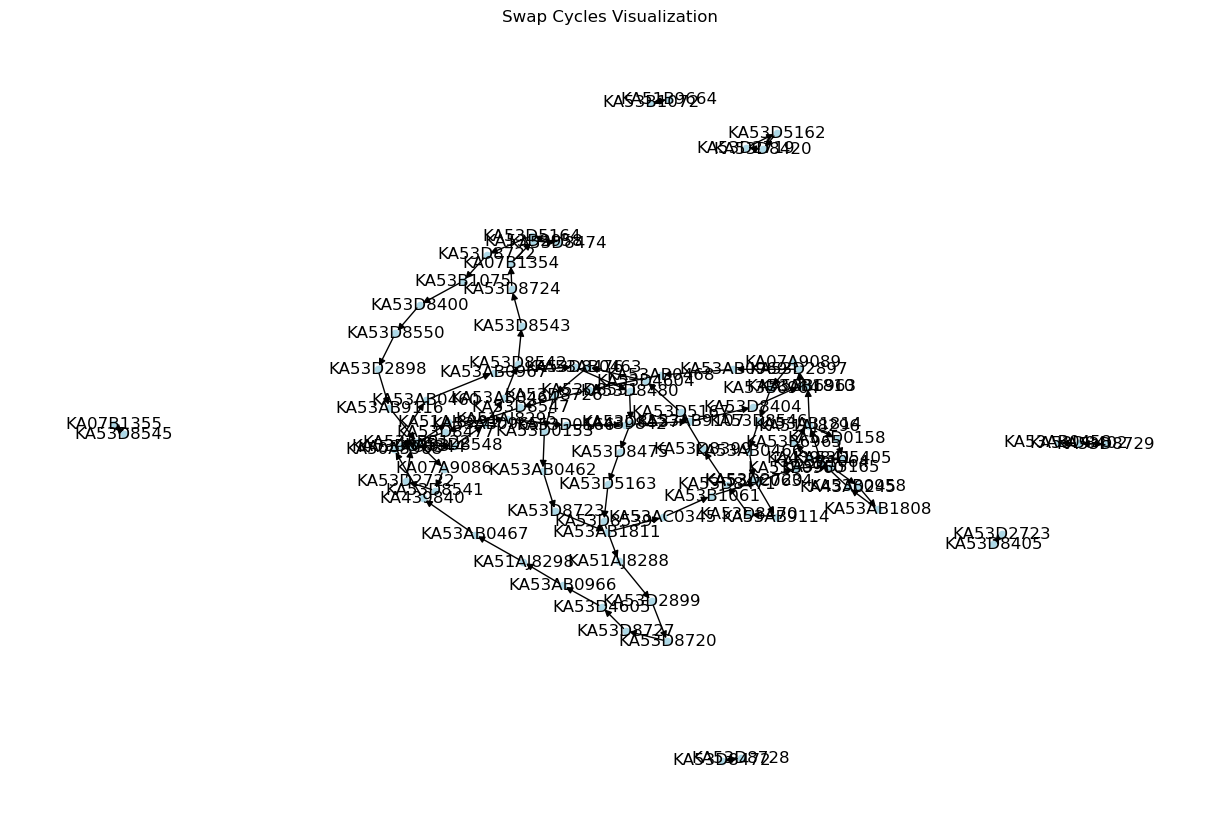

In [133]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

for f, t in zip(optimized_df['From Bus'], optimized_df['To Bus']):
    if f != t:
        G.add_edge(f, t)

plt.figure(figsize=(12,8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=20, node_color='lightblue', arrowsize=10)
plt.title("Swap Cycles Visualization")
plt.show()


In [135]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [142]:
optimized_df['dev'] = optimized_df['Original dead km'] - optimized_df['Optimized dead km']


In [143]:
import folium
from folium import plugins
from branca.element import Template, MacroElement

# Create base map with a clean, modern tile layer
m = folium.Map(location=[12.97,77.59], zoom_start=11, tiles="CartoDB.Positron")

# Feature groups for toggling
driver_layer = folium.FeatureGroup(name='Driver Points').add_to(m)
pickup_layer = folium.FeatureGroup(name='Pickup Points').add_to(m)
lines_layer = folium.FeatureGroup(name='Assignment Lines').add_to(m)

# Add markers and lines
for idx, row in optimized_df.iterrows():
    f_bus, t_bus = row['From Bus'], row['To Bus']
    f_lat, f_lon = driver_df.loc[f_bus, 'dlat'], driver_df.loc[f_bus, 'dlon']
    t_lat, t_lon = pickup_df.loc[t_bus, 'plat'], pickup_df.loc[t_bus, 'plon']
    f_popup = (f"<b>Driver Bus:</b> {f_bus}<br>"
               f"<b>Driver Route:</b> {driver_df.loc[f_bus, 'route']}<br>"
               f"<b>Institute:</b> {driver_df.loc[f_bus, 'cname']}")
    t_popup = (f"<b>Pickup Bus:</b> {t_bus}<br>"
               f"<b>Pickup Route:</b> {pickup_df.loc[t_bus, 'route']}<br>"
               f"<b>Institute:</b> {pickup_df.loc[t_bus, 'cname']}<br>"
               f"<b>Optimized Dead Km:</b> {row['Optimized dead km']:.2f}")

    # Driver marker: blue bus icon
    folium.Marker(
        [f_lat, f_lon],
        icon=folium.Icon(color='blue', icon='bus', prefix='fa'),
        popup=folium.Popup(f_popup, max_width=300),
        tooltip=f"Driver {f_bus}"
    ).add_to(driver_layer)

    # Pickup marker: green flag icon
    folium.Marker(
        [t_lat, t_lon],
        icon=folium.Icon(color='green', icon='flag', prefix='fa'),
        popup=folium.Popup(t_popup, max_width=300),
        tooltip=f"Pickup {t_bus}"
    ).add_to(pickup_layer)

    # Line from driver to pickup: color by change (red for increased km, green for reduced km)
    color = 'green' if row['dev'] > 0 else 'red' if row['dev'] < 0 else 'gray'
    folium.PolyLine(
        locations=[[f_lat, f_lon], [t_lat, t_lon]],
        color=color,
        weight=3,
        opacity=0.7,
        tooltip=f"{f_bus} → {t_bus} ({row['Optimized dead km']:.2f} km)"
    ).add_to(lines_layer)

# Layer control to toggle driver/pickup/lines
folium.LayerControl().add_to(m)

# Add a minimap
minimap = plugins.MiniMap(toggle_display=True, minimized=True)
m.add_child(minimap)

# Add fullscreen button
plugins.Fullscreen().add_to(m)

# Add measure tool
plugins.MeasureControl(primary_length_unit='kilometers').add_to(m)

# Add legend using custom HTML/CSS template
legend_html = """
{% macro html(this, kwargs) %}
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 200px; height: 140px; 
     z-index:9999; font-size:14px; background-color: white;
     border:2px solid grey; padding: 10px;">
<b>Legend</b><br>
<i class="fa fa-bus fa-2x" style="color:blue"></i> Driver Point<br>
<i class="fa fa-flag fa-2x" style="color:green"></i> Pickup Point<br>
<hr style="margin:5px 0;">
<span style="color:green;">&#8212;</span> Reduced Dead Km<br>
<span style="color:red;">&#8212;</span> Increased Dead Km<br>
<span style="color:gray;">&#8212;</span> Unchanged
</div>
{% endmacro %}
"""
legend = MacroElement()
legend._template = Template(legend_html)
m.get_root().add_child(legend)

# Save to HTML
m.save("Beautiful_Assignment_Map.html")


In [144]:
import plotly.colors as pc

num_chains = len(chains)
colors = pc.qualitative.Set3 * (num_chains // len(pc.qualitative.Set3) + 1)
colors = colors[:num_chains]


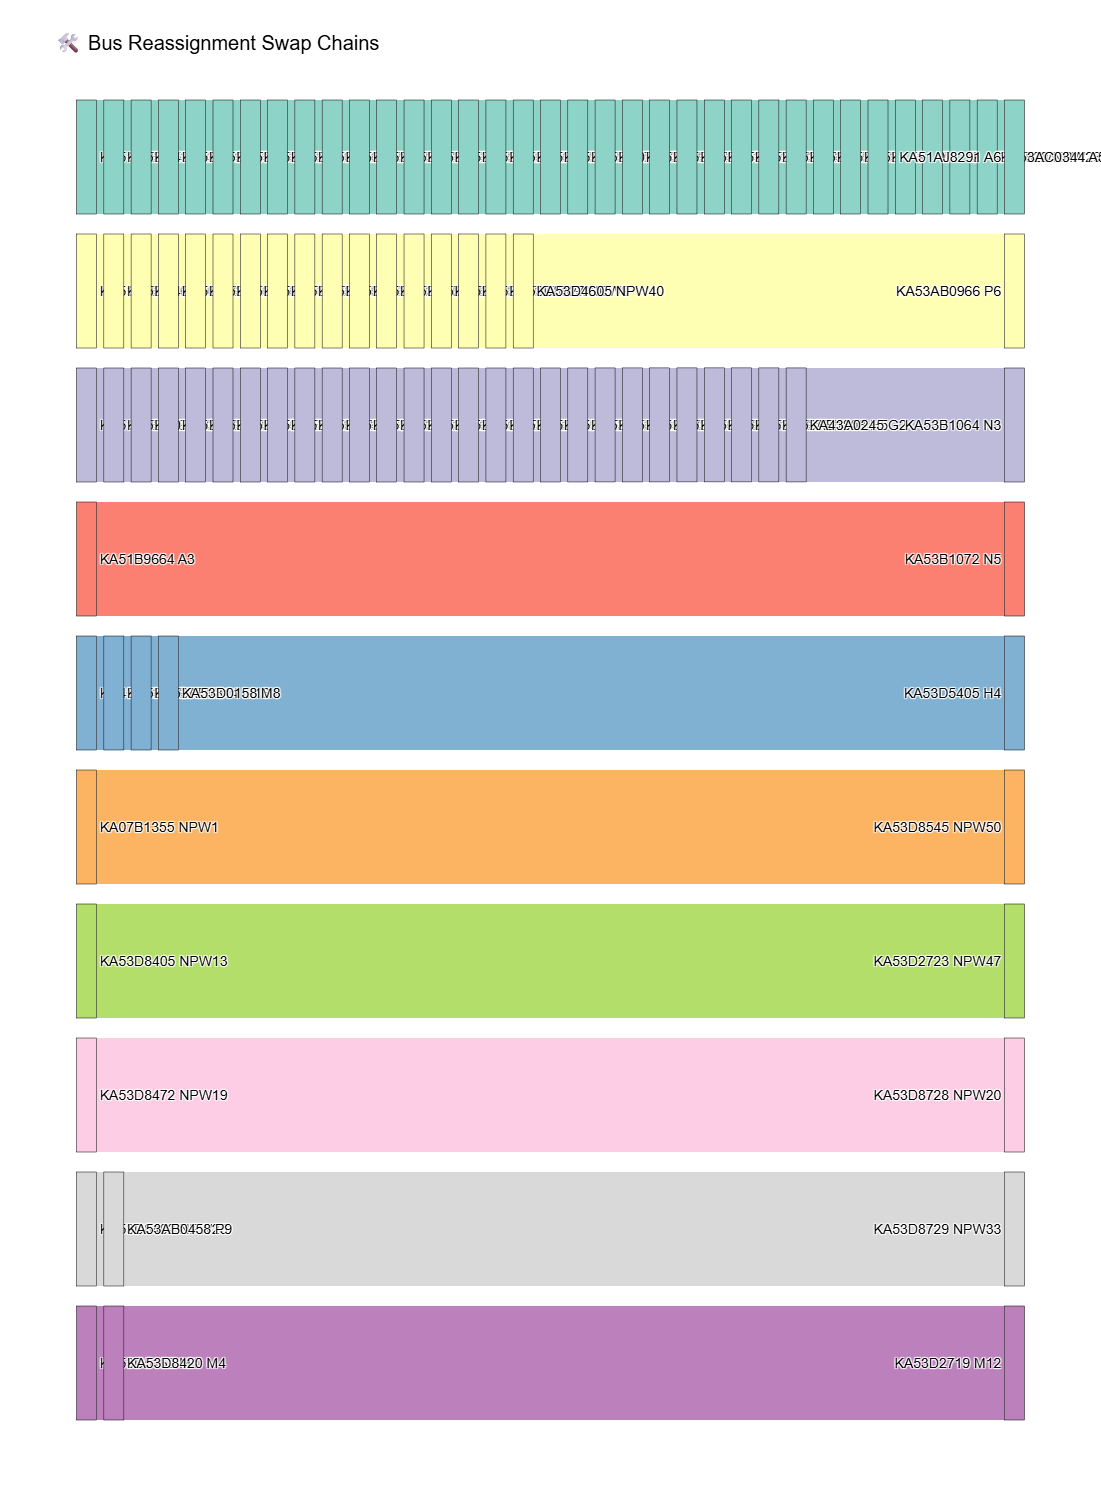

In [147]:
import plotly.graph_objects as go
import plotly.colors as pc

# Dummy example assuming chains and driver_df are defined
num_chains = len(chains)
colors = pc.qualitative.Set3 * (num_chains // len(pc.qualitative.Set3) + 1)
colors = colors[:num_chains]

nodes = []
links = []
node_labels = []
node_colors = []
label_index = {}
node_id = 0

for idx, chain in enumerate(chains):
    color = colors[idx]
    for i, bus in enumerate(chain):
        label = f"{bus}\n{driver_df.loc[bus, 'route']}" if bus in driver_df.index else bus
        if label not in label_index:
            label_index[label] = node_id
            node_labels.append(label)
            node_colors.append(color)
            node_id += 1
        if i > 0:
            links.append({
                'source': label_index[prev_label],
                'target': label_index[label],
                'value': 1,
                'color': color
            })
        prev_label = label

fig = go.Figure(data=[go.Sankey(
    arrangement="snap",
    node=dict(
        pad=20,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=node_labels,
        color=node_colors,
    ),
    link=dict(
        source=[l['source'] for l in links],
        target=[l['target'] for l in links],
        value=[l['value'] for l in links],
        color=[l['color'] for l in links],
        hovertemplate='From %{source.label} to %{target.label}'
    )
)])

fig.update_layout(
    title_text="🛠️ Bus Reassignment Swap Chains",
    font=dict(size=14, color="black", family="Arial"),  # ✅ Here instead of node
    width=1600,
    height=max(500, len(node_labels) * 15),
    paper_bgcolor="white",
    plot_bgcolor="white",
)

fig.show()
